In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

In [2]:
class LogisticRidgeCV:
    def __init__(self, preds, responses, lambdas, nfolds = 5, alpha = 1e-4, n_iters = 1000):
        '''
        A class that implements logistic regression with a ridge penalty with cross validation 
        to identify the optimal tuning parameter lambda.

        Args:
            preds (np.ndarray): A N x M array where N is the number of samples and M is the 
                number of predictors or features.
            responses (np.ndarray): A N-D array of one-hot indices corresponding to preds.
            lambdas (list): The different values of lambda to try.
            nfolds (int): The number of cross validation folds to use for each lambda given.
                Default is 5.
            alpha (float > 0): The learning rate. Default is 1e-4.
            n_iters (int > 0): The number of updates to the coefficient vector before stopping. 
        '''

        self.lambdas = lambdas 
        self.nfolds = nfolds
        self.alpha = alpha 
        self.n_iters = n_iters
        self._initialize(preds, responses)        

    def _initialize(self, preds, responses):
        '''
        This function initializes certain values needed for training and checks that certain
        arguments have appropriate values. 
        '''

        # shuffle the data
        self.x, self.y = self._shuffle_data(preds, responses)
        
        # get number of samples and number of features
        self.n_samples = self.x.shape[0]
        self.n_preds = self.x.shape[1]
        
        # get number of training classes 
        self.n_classes = np.unique(self.y).size
        
        # make one-hot response mat
        self.y = self._make_one_hot_responses(self.y, self.n_classes)
    
        # matrix to store the cross validation results 
        self.cv_vals = np.zeros([self.nfolds, len(self.lambdas)])

        # determine the number of validation samples and their inds based on nfolds 
        self.n_val_samples = int(np.ceil(self.n_samples / self.nfolds)) 
        self.val_inds = list(range(0, self.n_samples, self.n_val_samples))
        
        # create a tensor to store the trained coefficient vectors
        self.B_trained = np.zeros([self.nfolds, len(self.lambdas), self.n_preds + 1, self.n_classes])

        assert(all([lambda_val >= 0 for lambda_val in self.lambdas])), \
            'lambdas must not contain any negative values.'
        assert(self.alpha > 0), \
            'alpha must be positive.'
        assert(self.x.shape[0] == self.y.shape[0]), \
            "number of responses doesn't equal number of rows in preds."
        assert(self.n_iters > 0), \
            'n_iters should be > 0.'
        
    def _make_one_hot_responses(self, response_vector, n_classes):
        '''
        Takes a vector of class indices and makes them into a one-hot matrix.
        
        Args:
            response_vector (np.ndarray): A N-D vector of class indices.
            n_classes (np.ndarray): The number of unique classes.
            
        Returns:
            response_mat (np.ndarray): A N x K array with one-hot encoding of response_vector.
        '''
        
        response_vector = np.int64(response_vector)
        n_samples = response_vector.shape[0]
        response_mat = np.zeros([n_samples, n_classes])
        response_mat[np.arange(n_samples), response_vector] = 1
        return response_mat

    def _standardize(self, x, mean_vec, std_vec):
        '''
        Standardizes the columns of the design matrix (i.e. makes each column zero-centered 
        with a standard deviation of 1).
        
        Args:
            x (np.ndarray): The N x M design matrix with columns to be standardized.
            mean_vec (np.ndarray): The M-dimentional vector representing the means of the columns of x.
            std_vec (np.ndarray): The M-dimensional vector representing the stds of the columns of x.

        Returns:
            x_standardized (np.ndarray): The N x M design matrix, where the columns now have mean 0 and std 1.
        '''

        return (x - mean_vec) / std_vec 

    def _shuffle_data(self, preds, responses):
        '''
        Shuffles the rows of the design matrix and the responses. 

        Args:
            preds (np.ndarray): The N x M dimensional design matrix with N samples and M predictors.
            responses (np.ndarray): The N-dimensional response vector corresponding to preds. 

        Returns:
            preds_shuffled (np.ndarray): The N x M dimensional design matrix with permuted rows. 
            responses_shuffled (np.ndarray): The N-dimensional response vector with permuted values matching 
                preds_shuffled. 
        '''

        data = np.concatenate((preds, responses[:, None]), 1)
        np.random.shuffle(data)
        return data[:, :-1], data[:, -1]

    def _initialize_B(self):
        '''
        Initializes the coefficient matrix B for each new model with zero values. 

        Args: 
            None

        Returns:
            B (np.ndarray): An M + 1 x K dimensional vector of zeros.
        '''

        return np.zeros([self.n_preds + 1, self.n_classes])

    def predict(self, x):
        '''
        A function to compute predicted responses given predictors. Must be called after fit().

        Args:
            x (np.ndarray): An N x M design matrix to compute predicted responses from.

        Returns:
            y_hat (np.ndarray): An N x K matrix of predicted responses for x. 
        '''

        assert(self.mean_vec is not None and self.std_vec is not None), \
            'Model must be trained before predicting.'

        x = self._standardize(x, self.mean_vec, self.std_vec)
        x = self._add_intercept(x)
        preds = np.exp(np.matmul(x, self.B))
        return preds / np.sum(preds, 1)[:, None]

    def _get_folds(self, val_ind):
        '''
        Gets the appropriate validation and training sets given the CV iteration.

        Args:
            val_ind (int): The index of the validation set for the current CV iteration.

        Returns:
            x_train (np.ndarray): The training set design matrix.
            x_val (np.ndarray): The validation set design matrix.
            y_train (np.ndarray): The matrix of training responses.
            y_val (np.ndarray): The matrix of validation responses. 
        '''
        
        if val_ind + self.n_val_samples <= self.n_samples:
            val_inds = np.arange(val_ind, val_ind + self.n_val_samples)
        else:
            val_inds = np.arange(val_ind, self.n_samples)
            
        x_val = self.x[val_inds]
        x_train = np.delete(self.x, val_inds, axis = 0)
        y_val = self.y[val_inds]
        y_train = np.delete(self.y, val_inds, axis = 0)
        return x_train, x_val, y_train, y_val

    def _update(self, x, y, B, lambda_):
        '''
        Performs a single iteration of gradient descent to update the coefficient vector.

        Args:
            x (np.ndarray): The N x M + 1 training design matrix. 
            y (np.ndarray): The N x K matrix of responses corresponding to x.
            B (np.ndarray): The M + 1 x K vector of the current estimate of the coefficients.
            lambda_ (float): The tuning parameter lambda. 

        Returns:
            B_updated (np.ndarray): The M + 1 x K vector of coefficients updated slightly. 
        '''

        unnorm_prob_mat = np.exp(np.matmul(x, B))
        norm_prob_mat = unnorm_prob_mat / np.sum(unnorm_prob_mat, 1)[:, None]
        intercept_mat = B.copy()
        intercept_mat[1:] = 0
        B = B + self.alpha * (np.matmul(np.transpose(x), y - norm_prob_mat) - 2 * lambda_ * (B - intercept_mat))
        return B

    def score(self, x, y, B):
        '''
        Scores a given model given data and desired responses with categorical 
            crossentropy loss. 

        Args:
            x (np.ndarray): The N x M + 1 design matrix.
            y (np.ndarray): The N x K matrix of responses. 
            B (np.ndarray): The M + 1 x K matrix of coefficients.

        Returns:
            ce_loss (float): The cross-entropy loss between y and y_hat. 
        '''

        unnorm_prob_mat = np.exp(np.matmul(x, B))
        norm_prob_mat = unnorm_prob_mat / np.sum(unnorm_prob_mat, 1)[:, None]
        ce = -(1 / x.shape[0]) * np.sum(np.sum(y * np.log10(norm_prob_mat), 1))
        return ce
    
    def _add_intercept(self, x):
        '''
        Adds the intercept column of ones to the design matrix x.
        
        Args:
            x (np.ndarray): The N x M design matrix.
            
        Returns:
            x_augmented (np.ndarray): The N x M + 1 design matrix with the first column of ones.
        '''
        
        intercept_col = np.ones([x.shape[0], 1])
        return np.concatenate((intercept_col, x), 1)

    def fit(self):
        '''
        Implements the cross validation and retrains the model with the optimal lambda on the entire dataset.
        '''

        for i_lambda, lambda_ in enumerate(self.lambdas):
            for i_fold, val_ind in zip(range(self.nfolds), self.val_inds):
                # get the folds
                x_train, x_val, y_train, y_val = self._get_folds(val_ind)

                # standardize x 
                mean_vec, std_vec = np.mean(x_train, 0), np.std(x_train, 0)
                x_train = self._standardize(x_train, mean_vec, std_vec)
                x_val = self._standardize(x_val, mean_vec, std_vec)
                
                # add intercept column to design matrix
                x_train = self._add_intercept(x_train)
                x_val = self._add_intercept(x_val)

                # initialize Beta for this lambda and fold
                B = self._initialize_B()

                for iter in range(self.n_iters):
                    B = self._update(x_train, y_train, B, lambda_)

                # score this model and store the value 
                self.cv_vals[i_fold, i_lambda] = self.score(x_val, y_val, B)
                
                # save this coefficient vector
                self.B_trained[i_fold, i_lambda] = B

        # find the best lambda and retrain model
        self.best_lambda = self.lambdas[np.argmin(np.mean(self.cv_vals, 0))]
        self.mean_vec, self.std_vec = np.mean(self.x, 0), np.std(self.x, 0)
        x = self._standardize(self.x, self.mean_vec, self.std_vec)
        x = self._add_intercept(x)
        y = self.y.copy()
        self.B = self._initialize_B()
        
        for iter in range(self.n_iters):
            self.B = self._update(x, y, self.B, self.best_lambda)

# Load and Prepare the Training and Testing Datasets

In [3]:
train_fpath = 'TrainingData_N183_p10.csv'
test_fpath = 'TestData_N111_p10.csv'

In [4]:
train_df = pd.read_csv(train_fpath)
test_df = pd.read_csv(test_fpath)

In [5]:
train_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Ancestry
0,-10.901171,0.798743,-1.143301,-1.070960,11.856396,-2.265965,4.536405,1.519959,-2.214294,-0.671274,African
1,-9.990054,1.416821,-0.729626,-0.443621,10.418594,0.443514,2.640659,-4.637746,3.351629,-0.671274,African
2,-9.345388,2.913054,-0.921421,0.029173,10.672615,-2.052552,5.140476,-1.451096,0.444183,-0.671274,African
3,-11.221507,1.733021,-2.339817,0.045786,13.195087,-3.068897,2.863434,-2.259194,2.374566,-0.671274,African
4,-10.175158,2.066307,-0.785493,-0.632400,7.461272,-1.643509,0.715258,-3.982752,0.098681,-0.671274,African
...,...,...,...,...,...,...,...,...,...,...,...
178,4.562678,1.595991,-6.255160,-3.083079,0.155693,-2.509439,-1.186470,0.641546,2.893239,0.885596,NativeAmerican
179,4.559052,1.581629,-5.121037,-4.312312,0.021703,-0.787173,-1.838054,-0.118590,1.200644,0.885596,NativeAmerican
180,3.101335,1.477101,-5.759153,-2.083745,-0.750615,1.061579,-1.341655,-0.215556,-0.133415,0.885596,NativeAmerican
181,3.235086,-0.974829,-4.049595,0.020907,-0.489322,0.627622,0.087942,0.737715,3.262126,0.885596,NativeAmerican


In [6]:
test_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Ancestry
0,2.517683,5.464283,9.067873,-4.965928,-0.741937,0.039785,0.573279,-0.216918,2.454823,-0.671274,Unknown
1,6.077012,1.032867,-5.795883,-3.490064,-0.600204,-0.120803,1.243767,1.821390,-1.173053,2.442467,Unknown
2,1.016945,-2.913299,0.907702,1.233580,-1.983452,1.605964,2.674998,-0.732921,-2.157438,-0.671274,Unknown
3,-10.860926,2.545077,0.023950,-1.474450,0.372286,-2.609954,-2.794092,1.264747,-3.974644,-0.671274,Unknown
4,4.790262,3.621650,-1.442221,5.459907,-0.864235,-2.591185,-0.062762,0.515344,0.228729,-0.671274,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
106,-11.030349,1.712786,-1.392893,-0.163989,3.623641,-0.263645,-3.337796,2.279226,-2.632659,-0.671274,AfricanAmerican
107,-7.994173,0.045333,-0.738547,0.189793,-2.545140,-0.332066,0.026289,-1.840944,-0.456438,-0.671274,AfricanAmerican
108,-8.874531,2.074620,-2.060999,-0.898143,-1.372896,-3.175091,2.325163,-1.256258,-0.133253,-0.671274,AfricanAmerican
109,-7.017063,-0.199721,-1.469538,-1.997714,1.892038,-1.880466,-3.278863,-0.336890,0.042410,-0.671274,AfricanAmerican


In [7]:
# recode the categories
class_names = train_df['Ancestry'].unique().tolist()
n_classes = len(class_names)
train_df['AncestryRecoded'] = train_df['Ancestry'].apply(lambda x: class_names.index(x))
train_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Ancestry,AncestryRecoded
0,-10.901171,0.798743,-1.143301,-1.070960,11.856396,-2.265965,4.536405,1.519959,-2.214294,-0.671274,African,0
1,-9.990054,1.416821,-0.729626,-0.443621,10.418594,0.443514,2.640659,-4.637746,3.351629,-0.671274,African,0
2,-9.345388,2.913054,-0.921421,0.029173,10.672615,-2.052552,5.140476,-1.451096,0.444183,-0.671274,African,0
3,-11.221507,1.733021,-2.339817,0.045786,13.195087,-3.068897,2.863434,-2.259194,2.374566,-0.671274,African,0
4,-10.175158,2.066307,-0.785493,-0.632400,7.461272,-1.643509,0.715258,-3.982752,0.098681,-0.671274,African,0
...,...,...,...,...,...,...,...,...,...,...,...,...
178,4.562678,1.595991,-6.255160,-3.083079,0.155693,-2.509439,-1.186470,0.641546,2.893239,0.885596,NativeAmerican,4
179,4.559052,1.581629,-5.121037,-4.312312,0.021703,-0.787173,-1.838054,-0.118590,1.200644,0.885596,NativeAmerican,4
180,3.101335,1.477101,-5.759153,-2.083745,-0.750615,1.061579,-1.341655,-0.215556,-0.133415,0.885596,NativeAmerican,4
181,3.235086,-0.974829,-4.049595,0.020907,-0.489322,0.627622,0.087942,0.737715,3.262126,0.885596,NativeAmerican,4


In [8]:
# separate predictors from responses
X_train = np.float32(train_df.to_numpy()[:, :-2])
X_test = np.float32(test_df.to_numpy()[:, :-1])

Y_train = train_df['AncestryRecoded'].to_numpy()
Y_train_names = train_df['Ancestry'].tolist()

Y_test_names = test_df['Ancestry'].tolist()

# Instantiate and Traing the Model

In [9]:
logistic_ridge = LogisticRidgeCV(
    preds = X_train,
    responses = Y_train,
    lambdas = 10 ** np.arange(-4., 4.),
    n_iters = 10000
)

In [10]:
logistic_ridge.fit()

# Analyze the Model's Performance During Training

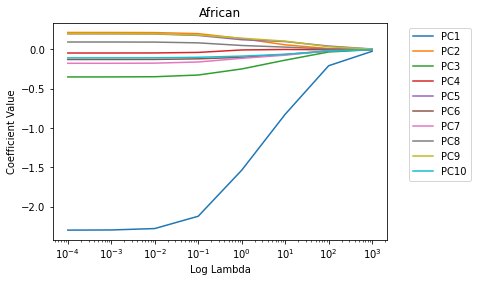

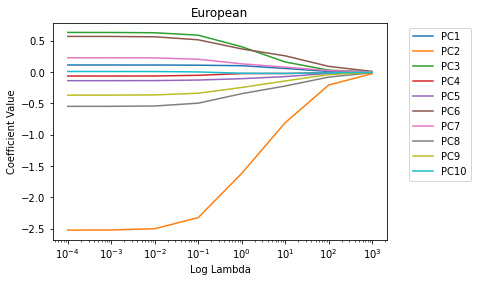

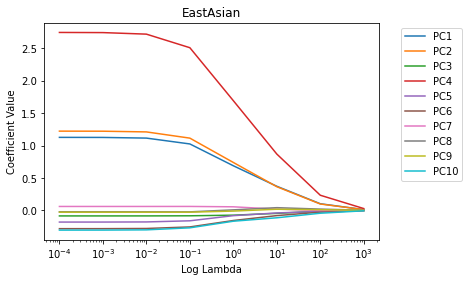

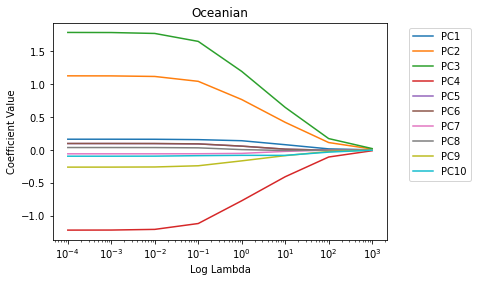

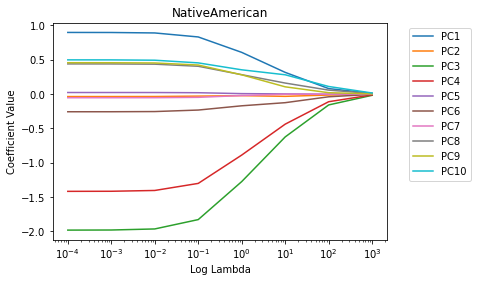

In [11]:
mean_betas = np.mean(logistic_ridge.B_trained, 0)

for class_ind, class_name in enumerate(class_names):
    mean_beta_k = mean_betas[..., class_ind]

    for pred_num in range(1, 1 + logistic_ridge.n_preds):
        plt.plot(
            logistic_ridge.lambdas, 
            mean_beta_k[:, pred_num],
            label = 'PC{}'.format(pred_num)
        )
    
    plt.xscale('log')
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    plt.xlabel('Log Lambda')
    plt.ylabel('Coefficient Value')
    plt.title(class_name)
    plt.show()

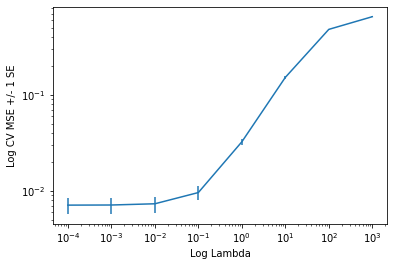

In [12]:
se = np.std(logistic_ridge.cv_vals, 0) / np.sqrt(logistic_ridge.cv_vals.shape[0])
plt.errorbar(
    logistic_ridge.lambdas, 
    np.mean(logistic_ridge.cv_vals, 0),
    yerr = se
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Log Lambda')
plt.ylabel('Log CV MSE +/- 1 SE')
plt.show()

In [13]:
print('Optimal lambda value: {}'.format(logistic_ridge.best_lambda))

Optimal lambda value: 0.0001


In [14]:
Y_train_hat = logistic_ridge.predict(X_train)
Y_train_class = np.argmax(Y_train_hat, 1)
print('Training Accuracy: {}'.format(np.mean(Y_train_class == Y_train)))

Training Accuracy: 1.0


# Predict on the Test Set

In [15]:
Y_test_hat = logistic_ridge.predict(X_test)
Y_test_class = np.argmax(Y_test_hat, 1)

In [16]:
# add these predictions to the test dataframe
new_df_col_names = ['{}Prob'.format(class_name) for class_name in class_names] + ['ClassPredInd']
prob_and_ind_array = np.concatenate((Y_test_hat, Y_test_class[:, None]), 1)
new_df = pd.DataFrame(prob_and_ind_array, columns = new_df_col_names)
test_anc_with_preds = pd.concat([test_df['Ancestry'], new_df], axis = 1)
test_anc_with_preds['ClassPredName'] = test_anc_with_preds['ClassPredInd'].apply(lambda x: class_names[int(x)])

In [17]:
print(test_anc_with_preds.to_string())

            Ancestry  AfricanProb  EuropeanProb  EastAsianProb  OceanianProb  NativeAmericanProb  ClassPredInd   ClassPredName
0            Unknown     0.000348      0.000265       0.000142      0.999074            0.000171           3.0        Oceanian
1            Unknown     0.000057      0.000600       0.000100      0.000123            0.999119           4.0  NativeAmerican
2            Unknown     0.000884      0.992759       0.005403      0.000670            0.000285           1.0        European
3            Unknown     0.992049      0.000587       0.000214      0.006852            0.000298           0.0         African
4            Unknown     0.000066      0.000024       0.999733      0.000023            0.000155           2.0       EastAsian
5            Mexican     0.001554      0.025035       0.000135      0.000387            0.972889           4.0  NativeAmerican
6            Mexican     0.004734      0.100846       0.000942      0.004215            0.889263           4.0 

In [18]:
test_true_with_probs = test_anc_with_preds.loc[:, 'Ancestry':'NativeAmericanProb']
test_true_with_probs_long = pd.melt(
    test_true_with_probs,
    id_vars = ['Ancestry'],
    var_name = 'AncestryPred',
    value_name = 'Probability'
)
test_true_with_probs_long['AncestryPred'] = test_true_with_probs_long['AncestryPred'].apply(lambda x: x.split('Prob')[0])

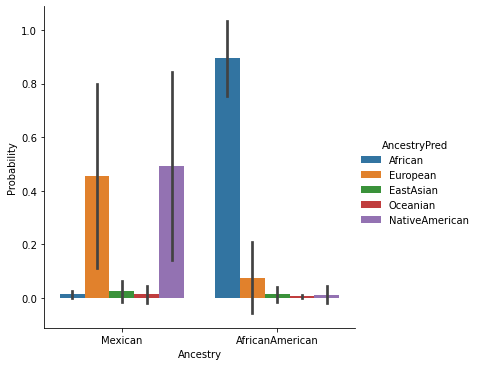

In [19]:
seaborn.catplot(
    data = test_true_with_probs_long[test_true_with_probs_long['Ancestry'] != 'Unknown'],
    kind = 'bar',
    x = 'Ancestry',
    y = 'Probability',
    hue = 'AncestryPred',
    ci = "sd"
)
plt.show()

According to the model, all indivduals with Unknown ancestry have a single class with probability 
close to 1, whereas the other classes have probability close to 0. This is similar in the individuals
with African American ancestry, because the model assigned high probability to the African ancestry 
class to each of these individuals. In the Mexican individuals, however, there is an equal contribution on 
average from both European and Native American ancestries. This is likely because the ancestors of the 
African American individuals probably came only from Africa due to the slave trade, but the ancestors 
of the Mexican individuals were probably of both European descent (e.g. from countries such as Spain due 
to colonization) as well as those of Native American descent. 